# Phase 3: Producing and Implementing
- Python, Pandas and Matplotlib: Use Python Pandas to read and manipulate data. Create relevant charts
and visualisations using Matplotlib.
- User Interface: How does the user find and generate the data? In a separate Python program, create an
intuitive text-based or graphical user interface (GUI). For full marks, you need a GUI.

## Get Your Data: Acquire any data you need, whether it be from .txt files, .csv files or APIs. For full marks, you need to be using APIs.
I hope FTP counts as an API

In [13]:
# File locations
files = {
    'temps.zip': '/anon/home/ncc/www/change/ACORN_SAT_daily/v2.4-raw-data-and-supporting-information.zip',
    'rain.tar': '/anon/home/ncc/www/change/HQdailyR/HQ_daily_prcp_txt.tar',
    'stations.txt': '/anon/gen/clim_data/IDCKWCDEA0/tables/stations_db.txt'
}
# ftp://134.178.253.145/anon/gen/radar_transparencies/ has some imgs
welcome = ""

In [ ]:
# A little options menu thingo :)
import ipywidgets as widgets
from IPython.display import display
import os, shutil

cacheWs = [
    widgets.Checkbox(
        value=False,
        description='Force refresh cache',
        indent=True
    ),
    widgets.HTML(
        value="",
    ),
    widgets.Button(
        description="Refresh status"
    )
]

removeBtn = widgets.Button(
    description="Delete cache"
)

ws = [
    widgets.HTML(
        value="<h1>Caching options</h1>Please note that it <i>will</i> use cached files if they exist in the cache directory unless you specify force refresh.<br>The cache option just caches the files when downloaded, so it's faster but takes up more space.",
    ),
    widgets.Checkbox(
        value=True,
        description='Cache?',
        indent=False
    ),
    widgets.VBox([
        widgets.HBox(cacheWs),
        widgets.HBox([widgets.HTML(value="&nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp &nbsp"),removeBtn])])
]

def isCached():
    return {i: os.path.exists('./cache/'+i) for i in files.keys()}

def RefreshStatus(change):
    cacheWs[1].value = "Cache status: <b>Checking...</b>"
    cacheds = isCached()
    numCached = len([i for i in cacheds if cacheds[i]])
    if numCached == 1:
        cacheWs[1].value = f"Cache status: <b>THERE IS 1 FILE CACHED OUT OF {len(cacheds)}</b>"
    else:
        cacheWs[1].value = f"Cache status: <b>THERE ARE {numCached} FILES CACHED OUT OF {len(cacheds)}</b>"


def removeCache(change):
    shutil.rmtree('./cache')
    os.mkdir('./cache')

ws[1].observe(RefreshStatus, names='value')
cacheWs[2].on_click(RefreshStatus)
removeBtn.on_click(removeCache)

RefreshStatus(None)

display(widgets.VBox(ws))


In [14]:
# Imports
import ftplib, io
import zipfile, tarfile

# Checking the cache
allcached = isCached()
cache = ws[1].value
force = cacheWs[0].value
cacheds = ([] if (not cache) or force else [i for i in allcached if allcached[i]])
fullyCached = len(cacheds) == len(allcached)
print("Caching status: "+('Force redownloading all cached' if force else (
    f'Fully cached all {len(allcached)} file{"s" if len(allcached) != 1 else ""}' if fullyCached else (
        f'{len(cacheds)} file{"s" if len(cacheds) != 1 else ""} cached out of {len(allcached)}' if len(cacheds) > 0 else 'Not cached'
)))+f". Will download {str(len(allcached)-len(cacheds))} file{'s' if len(allcached)-len(cacheds) != 1 else ''} and will {'not ' if not cache else ''}cache them once downloaded.\n")

def getFiles():
    global welcome
    if fullyCached:
        print("Cache has all the files! Using them.")
        return {i: i for i in cacheds}
    fs = {}
    print("Connecting to ftp server...")
    server = ftplib.FTP()
    server.connect("134.178.253.145") # Also known as ftp.bom.gov.au
    print("Logging in...")
    server.login()
    welcome = server.welcome
    for i in files:
        if i in cacheds:
            print(f"Using cached file '{i}'...")
            fs[i] = i
            continue
        print(f"Downloading file '{i}' at ftp://ftp.bom.gov.au{files[i]} (may take a while)...")
        newf = io.BytesIO()
        server.retrbinary('RETR '+files[i], newf.write)
        fs[i] = newf
        if cache:
            print(f"Caching file '{i}'...")
            with open(f'./cache/{i}', 'wb') as f:
                f.write(newf.getvalue())
    print("Quitting server connection...")
    server.quit()
    return fs

def extractFiles(fs):
    extracted = []
    for i in fs:
        if i.endswith('.txt'):
            print(f"Opening text file '{i}'...")
            if isinstance(fs[i], str):
                extracted.append(open(f'./cache/{fs[i]}').read())
            else:
                extracted.append(fs[i].getvalue().decode())
            continue
        typ = 'tar' if i.endswith('.tar') else 'zip'
        if isinstance(fs[i], str):
            print(f"Extracting cached {typ} file '{i}'...")
            fs[i] = f'./cache/{fs[i]}'
        else:
            print(f"Extracting downloaded {typ} file '{i}'...")
        if i.endswith('.tar'):
            if isinstance(fs[i], str):
                extracted.append(tarfile.open(fs[i]))
            else:
                extracted.append(tarfile.open(fileobj=fs[i]))
        else:
            extracted.append(zipfile.ZipFile(fs[i]))
    return extracted

fs = getFiles()
print("All files collected! Extracting...")
xtracteds = extractFiles(fs)

print("All files extracted!!! :)")

Caching status: Fully cached all 3 files. Will download 0 files and will cache them once downloaded.

Cache has all the files! Using them.
All files collected! Extracting...
Extracting cached zip file 'temps.zip'...
Extracting cached tar file 'rain.tar'...
Opening text file 'stations.txt'...
All files extracted!!! :)


In [15]:
print(welcome)

In [17]:
import pandas as pd
z = xtracteds[2]
spl = [(int(i[:8]), i[8:12].strip(), i[12:18].strip(), i[18:59].strip(), i[59:75].strip(), float(i[75:84]), float(i[84:])) for i in z.split('\n') if i != '']
names = ["Location", "State", "???", "Name", "????", "Lat", "Long"]
locs = pd.DataFrame({names[j]: {str(i): spl[i][j] for i in range(len(spl))} for j in range(len(names))})#'Location,State,???,Name,????,Lat,Long\n'+z)
# Until I find what it is, I'll remove the unknown columns
locs = locs.drop(columns=['???', '????'])
"""
import re
from io import StringIO
z = xtracteds[1]
locs = pd.read_csv(StringIO("Location,Lat,Long,Elevation,Name\n"+re.sub('^(.*?) (.*?) (.*?) (.*?) (.*)', r'\1,\2,\3,\4,\5', z.extractfile('HQDR_stations.txt').read().decode(), flags=re.M)))
"""
locs

,Location,State,Name,Lat,Long
0,15590,NT,ALICE SPRINGS AIRPORT,-23.7951,133.8890
1,14272,NT,BATCHELOR AIRPORT,-13.0544,131.0252
2,14723,NT,BORROLOOLA AIRPORT,-16.0755,136.3041
3,14954,NT,BRADSHAW,-14.9408,130.8091
4,14808,NT,BRADSHAW - ANGALLARI VALLEY (DEFENCE),-15.4397,130.5731
...,...,...,...,...,...
503,13011,WA,WARBURTON AIRFIELD,-26.1317,126.5839
504,13044,WA,WILUNA AERO,-26.6273,120.2195
505,109521,WA,WITCHCLIFFE WEST,-34.0258,115.0637
506,1006,WA,WYNDHAM AERO,-15.5100,128.1503


In [18]:
def getInfo(id):
    part = locs[locs['Location'] == id]
    if len(part) == 0:
        return {
        'Name': 'Unknown', 
        'State': 'Unknown', 
        'Lat': 'Unknown', 
        'Long': 'Unknown'
    }
    return {
        'Name': part.Name.values[0], 
        'State': part.State.values[0], 
        'Lat': part.Lat.values[0], 
        'Long': part.Long.values[0]
    }
getInfo(72161)

{'Name': 'CABRAMURRA SMHEA AWS',
 'State': 'NSW',
 'Lat': -35.9371,
 'Long': 148.3779}

In [19]:
z = xtracteds[0]
dirs = [i for i in z.namelist() if i.startswith('raw-data/') if i != 'raw-data/Raw data.7z' and i != 'raw-data/']
datas = [z.open(i).read().decode() for i in dirs]
print(z.open("readme.txt").read().decode())
# This is the format for the data!

This set of files contains the following:

- homogenised ACORN-SAT data
- raw station data for stations corresponding to the ACORN-SAT locations
- a file (primarysites.txt) with information on which site is the primary site for each ACORN-SAT occasion and for which period of time
(in most cases, there will be two or three primary sites which make up the input data for the overall ACORN-SAT record)
- a summary of adjustments and reference periods and stations. This information is also contained in the station catalogue.
- each of the transfer functions for these adjustments.

Format of raw data files

These file names have the file name hqnewNNNNNN, where NNNNNN is the station number.

Each day of data has the format:

NNNNNN YYYYMMDD  XXX  NNN

where NNNNNN is the station number, YYYYMMDD is the date, XXX is the maximum temperature in tenths of degrees C
(e.g. 251 = 25.1 C) and NNN is the minimum temperature. Missing data is shown as -999.

These data files have been quality controlled

In [20]:
import pandas as pd
from io import StringIO
import re
def clean_data(dat):
    cleaned = re.sub(' +', ',', # Replace the spaces that *were* the deliminers to commas. Theer were not the same number of spaces each time either.
                     re.sub('\r\n......', '\n', dat) # Remove the station number and \r. The station number is the same every time, and returned along with the dataframe.
    ).replace(',\n', '\n' # Because the spaces are a pain and all over the place!
                         )[6:] # The first station number does not get cleaned, so remove it here. 
    df = pd.read_csv(StringIO('Date,MaxTemp,MinTemp\n'+cleaned))
    df = df.drop(df[(df.MaxTemp == -999) | (df.MinTemp == -999)].index) # Remove all missing data coz it's useless
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d') # Turn the dates into **real** dates!
    df['MaxTemp'] = df['MaxTemp']/10 # Adjust the temperature because of how it was stored
    df['MinTemp'] = df['MinTemp']/10 # Adjust the temperature because of how it was stored
    return df

print('Cleaning data (may take a short while)...')
alls = {i[:6]: clean_data(i) for i in datas}
print('Done!')

Cleaning data (may take a short while)...
Done!


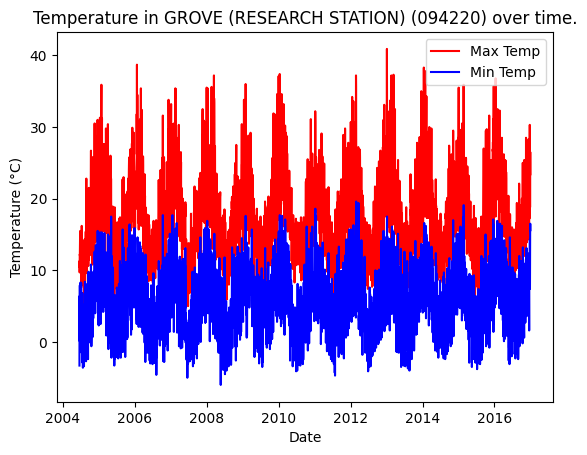

In [21]:
import matplotlib.pyplot as plt
from random import randint
place = list(alls.keys())[randint(0, len(alls)-1)]
# place = '27042'
df = alls[place]
plt.plot(df['Date'], df['MaxTemp'], label='Max Temp', color="red")
plt.plot(df['Date'], df['MinTemp'], label='Min Temp', color="blue")
plt.legend()
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature in {getInfo(int(place))["Name"]} ({place}) over time.')
plt.show()
# PLEASE NOTE: If there is a gap, it is because there is no data for that time. This is not an error.


In [22]:
from unlzw3 import unlzw
z = xtracteds[1]
dirs = z.getnames()
dirs.remove('HQDR_stations.txt')
print()
datas = {}
j = 0
for i in dirs:
    j += 1
    print(f"\rUnzipping files (Will be a while)... {j} / {len(dirs)}", end="")
    datas[i] = unlzw(z.extractfile(i).read()).decode()
print("\nDone!")


Unzipping files (Will be a while)... 151 / 151
Done!


In [23]:
import pandas as pd
from io import StringIO
import re
def clean_data(dat):
    # Info is stored as: "?????         StationNumber DateFrom DateTo missing_value=MISSINGVALUE Name\r\n"
    info = dat[:dat.index("\r")-1][4:].strip().split(' ')
    cleaned = re.sub(' +', ',', # Replace the spaces that *were* the deliminers to commas.
                     dat[dat.index("\n")+1:].replace('\r\n', '\n') # Make the newlines consistent
    )
    df = pd.read_csv(StringIO('Date,Rainfall\n'+cleaned))
    df = df.drop(df[df.Rainfall == float(info[3][14:])].index) # Remove all missing data coz it's useless
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d') # Turn the dates into **real** dates!
    return df, {"Station": int(info[0]), "Name": " ".join(info[4:])}

print("Cleaning data (may take a short while)...")
cleanDatas = {}
stationMap = {}
for i in datas:
    df, info = clean_data(datas[i])
    cleanDatas[info['Station']] = df
    stationMap[info['Station']] = info['Name']
print("Done!")

Cleaning data (may take a short while)...
Done!


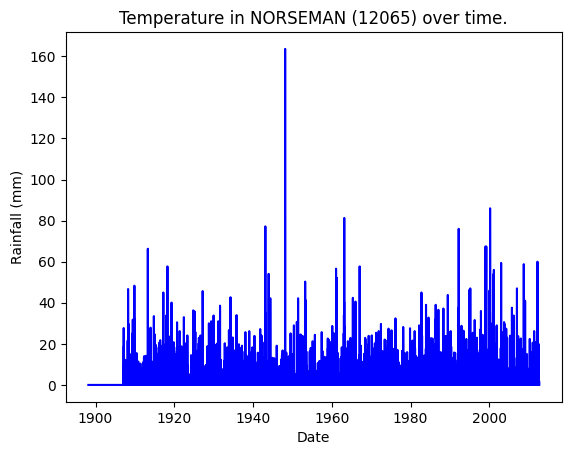

In [30]:
import matplotlib.pyplot as plt
from random import randint
place = list(cleanDatas.keys())[randint(0, len(cleanDatas)-1)]
# place = '27042'
df = cleanDatas[place]
plt.plot(df['Date'], df['Rainfall'], color="blue")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)') # At least, I'm *assuming* it's in mm
plt.title(f'Temperature in {stationMap[place]} ({place}) over time.')
plt.show()
# PLEASE NOTE: If there is a gap, it is because there is no data for that time. This is not an error.